# Plotting programs

This notebook illustrates a secondary feature of the plotting library - plotting program related quantities such as

- Program spending
- Coverage

The functionality is build on the standard plotting library - as described in the plotting documentation, the general workflow is to 

1. Create a `PlotData` instance containing the values to be rendered on a plot
2. Pass the `PlotData` object to `plot_series` or `plot_bars` to render the figure

The strategy is to construct a `PlotData` object that contains program-related data. Then, `plot_series` and `plot_bars` can be used as normal, together with all of the other functionality for assigning colours, bar plot stacking, legend management, and figure saving. 

First, we will perform a simulation using programs

In [1]:
# IMPORTS
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('..')
import atomica as au
import matplotlib.pyplot as plt
import numpy as np
import sciris as sc
from IPython.display import display, HTML

CSS = """
.output {
    flex-flow: row wrap;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [2]:
# Make demo project and default budget run
P = au.demo(which='tb')
instructions = au.ProgramInstructions(2018)
result1 = P.run_sim(P.parsets[0],P.progsets[0],progset_instructions=instructions,result_name='Default budget')

# Do a simple budget scenario so that we have different spending
alloc = {'BCG': 365000, 'PCF': 22568000, 'ACF': 22282133, 'ACF-p': 793333, 'HospDS': 108461100, 'HospMDR': 7205000, 'HospXDR': 1346000, 'AmbDS': 0, 'AmbMDR': 0, 'XDRnew': 951200, 'PrisDS': 1414500, 'PrisDR': 220000}
instructions = au.ProgramInstructions(alloc=alloc,start_year=2018)
result2 = P.run_sim(P.parsets[0],P.progsets[0],progset_instructions=instructions,result_name='Modified budget')

# Do a budget scenario with time-varying spending
alloc = {'ACF': au.TimeSeries([2018,2030],[2e8,1.5e8]),'BCG': au.TimeSeries([2018,2025],[2e7,3e7])}
instructions = au.ProgramInstructions(alloc=alloc,start_year=2018)
result3 = P.run_sim(P.parsets[0],P.progsets[0],progset_instructions=instructions,result_name='Time-varying budget')

Elapsed time for running "default": 1.03s


Elapsed time for running "default": 1.06s


Elapsed time for running "default": 1.23s


Elapsed time for running "default": 1.04s


### Creating `PlotData` from programs

To make a standard plot of model outputs, you pass a `Result` object to the `PlotData` constructor:

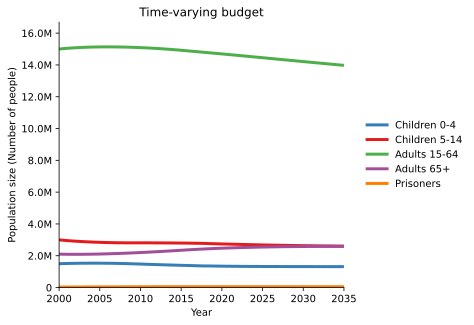

In [3]:
d = au.PlotData(result3,outputs='alive',pops='all',project=P)
au.plot_series(d,axis='pops');

This constructor is specific to plotting model outputs i.e. the values associated with the integration objects in a `Model` such as compartments, characteristics, parameters, and links. Therefore, the `outputs` argument should correspond to the code name of one of these quantities. 

To plot programs, you instead construct a `PlotData` instance using the `au.PlotData.programs()` static method. For example:

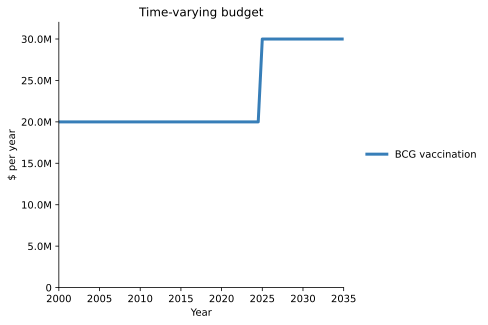

In [4]:
d = au.PlotData.programs(result3,outputs='BCG')
au.plot_series(d);

For this method, the `outputs` argument should correspond to the code name of _programs_, and the `pop` argument is not supported because the program quantities for spending and coverage are not population specific.

## Plotting spending and coverage

`au.PlotData.programs()` takes an optional argument, `quantity`, that selects whether to extract values associated with

- `spending` which are budget amounts from the `alloc`
- `coverage_eligible` which is the number of people reached by the program. This is equal to the sum of the compartment sizes for all compartments and populations the program is marked as reaching in the progbook
- `coverage_fraction` - this is the fraction of the available people covered by the program, and is equal to `coverage_number/coverage_eligible` with a maximum value of `1.0`
- `coverage_number` which is the number of people actually covered by the program - this is returned as a number of people covered per year

<div class='alert alert-warning'>
Note that program coverages plotted here are always on an individual program basis, prior to any modality interactions
</div>


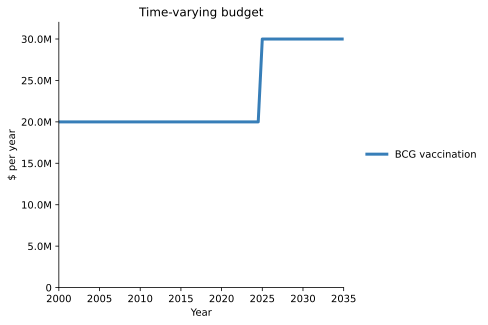

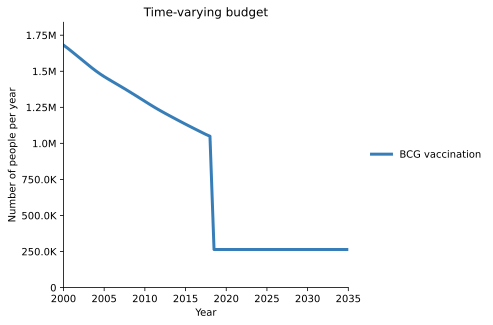

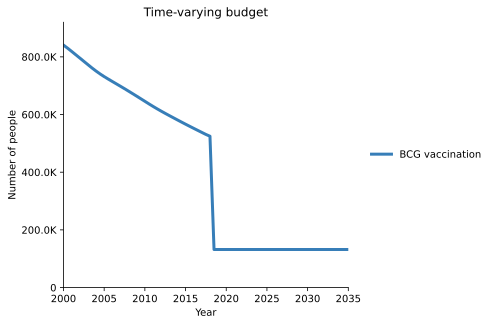

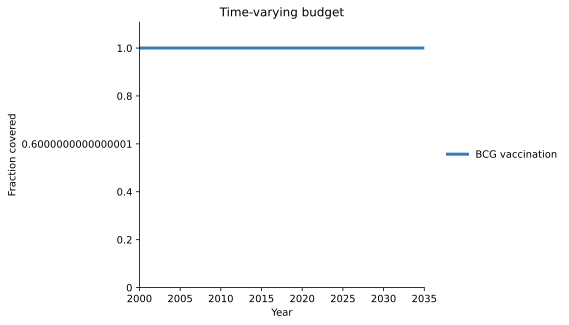

In [5]:
d = au.PlotData.programs(result3,outputs='BCG',quantity='spending')
au.plot_series(d);

d = au.PlotData.programs(result3,outputs='BCG',quantity='coverage_number')
au.plot_series(d);

d = au.PlotData.programs(result3,outputs='BCG',quantity='coverage_eligible')
au.plot_series(d);

d = au.PlotData.programs(result3,outputs='BCG',quantity='coverage_fraction')
au.plot_series(d);

<div class='alert alert-danger'>
Spending values are interpolated onto every time-step but are only used after the program start year. Currently this is not visually indicated on the plot.
</div>

As with plotting normal results, you can pass in a `list` of `Result` objects to compare budget quantities in two different simulations. Here, our different result objects correspond to different budget scenarios:

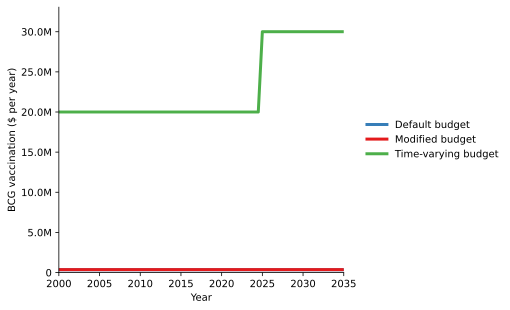

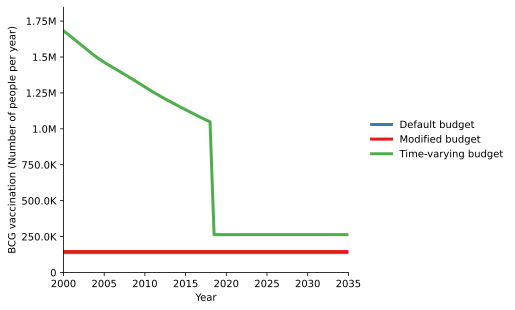

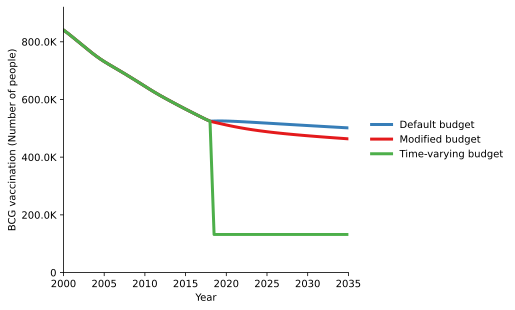

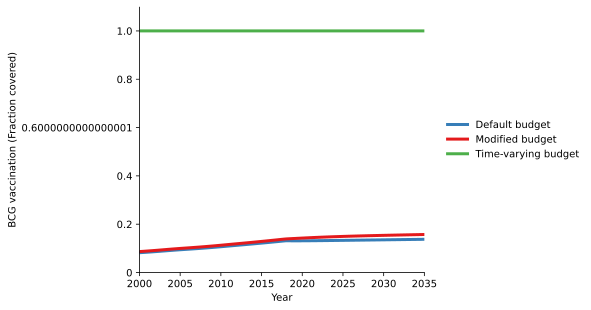

In [6]:
d = au.PlotData.programs([result1,result2,result3],outputs='BCG',quantity='spending')
au.plot_series(d,axis='results');

d = au.PlotData.programs([result1,result2,result3],outputs='BCG',quantity='coverage_number')
au.plot_series(d,axis='results');

d = au.PlotData.programs([result1,result2,result3],outputs='BCG',quantity='coverage_eligible')
au.plot_series(d,axis='results');

d = au.PlotData.programs([result1,result2,result3],outputs='BCG',quantity='coverage_fraction')
au.plot_series(d,axis='results');

## Bar plots and selecting times

A common task is making a bar plot for allocations in specific year(s). The simulation is fundamentally run with a spending value at each timestep, and the `PlotData` object has values for every simulation time, as shown above. To select a single year, simply interpolate the `PlotData` object onto the year that you want to plot. This parsimoniously handles time-varying budgets. 

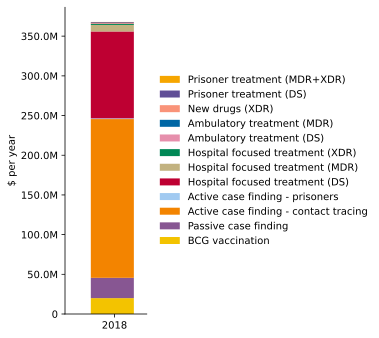

In [7]:
d = au.PlotData.programs(result3,quantity='spending')
d.interpolate(2018)
au.plot_bars(d,stack_outputs='all');

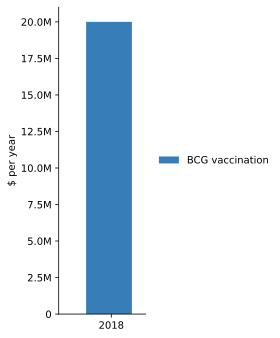

In [8]:
d = au.PlotData.programs(result3,outputs='BCG',quantity='spending')
d.interpolate(2018)
au.plot_bars(d);

As with normal `PlotData` objects, if you specify multiple outputs, they will be rendered as separate bar elements, and can optionally be stacked

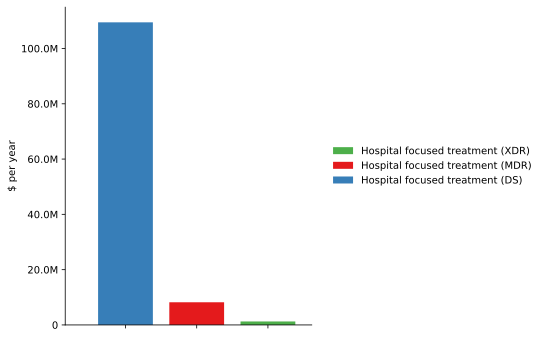

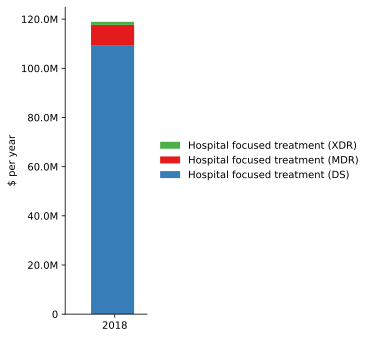

In [9]:
d = au.PlotData.programs(result3,outputs=['HospDS','HospMDR','HospXDR'],quantity='spending')
d.interpolate(2018)
              
au.plot_bars(d);
au.plot_bars(d,stack_outputs='all');

Notice how as usual, changing the stacking for the bar plot does not require assembling a new `PlotData` object, it is simply rendering the same data in a different style. If you interpolate onto multiple years, these will be rendered as normal by `plot_bars`:

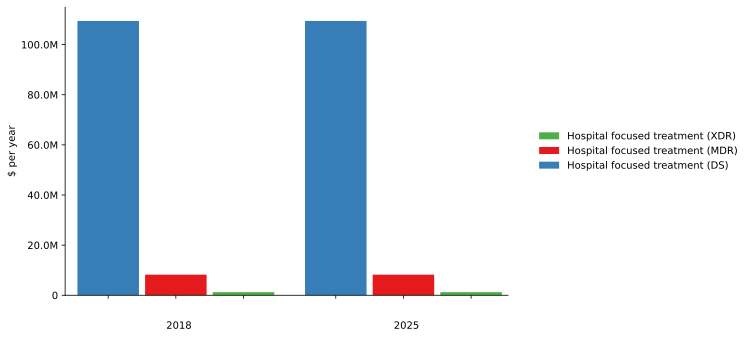

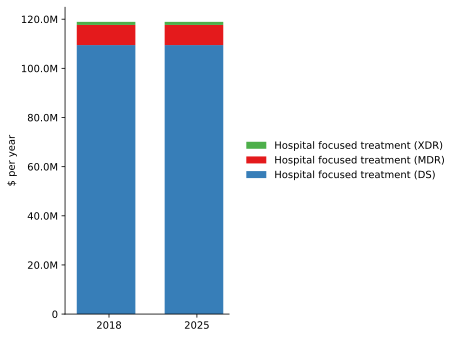

In [10]:
d = au.PlotData.programs(result3,outputs=['HospDS','HospMDR','HospXDR'],quantity='spending')
d.interpolate([2018,2025])
              
au.plot_bars(d);
au.plot_bars(d,stack_outputs='all');

Similarly, if you pass in multiple results, these will also be handled as normal by `plot_bars` even when combined with multiple years:

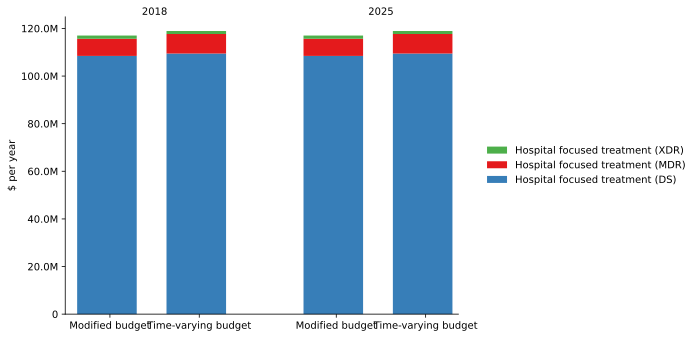

In [11]:
d = au.PlotData.programs([result2,result3],outputs=['HospDS','HospMDR','HospXDR'],quantity='spending')
d.interpolate([2018,2025])
au.plot_bars(d,stack_outputs='all');

## Time aggregation

To aggregate values over time, you can pass in an argument `t_bins` which behaves the same as for standard `PlotData` objects. However, unlike normal `PlotData` objects, the time aggregation type is fixed because only certain aggregations make sense in the context of programs:

- `spending` which is in units of '\$/year' will be integrated over time
- `coverage_eligible` (in units of 'people') will be averaged over time
- `coverage_fraction` (which is dimensionless) will be averaged over time
- `coverage_number` (in units of 'people/year') will be integrated over time

Note that `coverage_number` being integrated over time typically only makes sense for treatment-style programs rather than continuous ART-style programs. 

You can specify a scalar to aggregate over fixed bin sizes, or bin edges to aggregate over a specific time period:

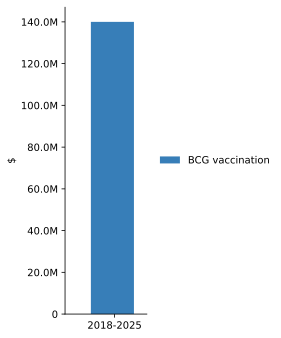

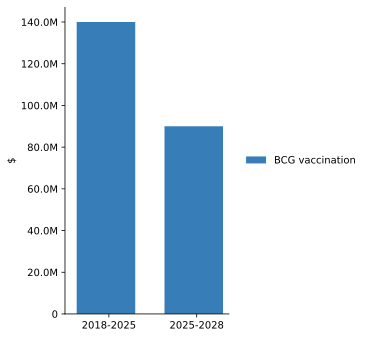

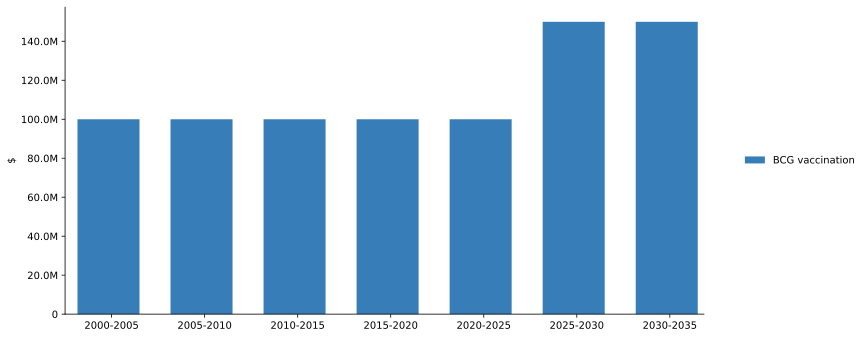

In [12]:
# Single time bin
d = au.PlotData.programs(result3,outputs=['BCG'],quantity='spending',t_bins=[2018,2025])
au.plot_bars(d,stack_outputs='all');

# Unequal bins
d = au.PlotData.programs(result3,outputs=['BCG'],quantity='spending',t_bins=[2018,2025,2028])
au.plot_bars(d,stack_outputs='all');

# 5-year bins, showing scale-up in spending
d = au.PlotData.programs(result3,outputs=['BCG'],quantity='spending',t_bins=5)
au.plot_bars(d,stack_outputs='all');

These behave in the usual way when there are multiple outputs, results, and time bins:

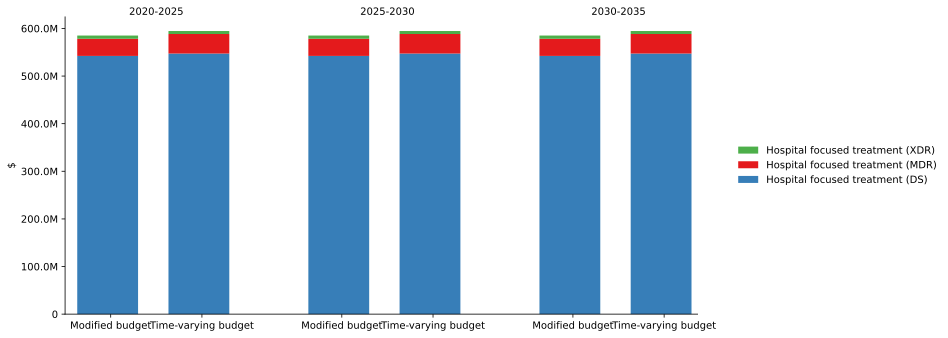

In [13]:
d = au.PlotData.programs([result2,result3],outputs=['HospDS','HospMDR','HospXDR'],quantity='spending',t_bins=np.arange(2020,2040,5))
au.plot_bars(d,stack_outputs='all',outer='times');

Here is a demonstration of the automatic selection of addition vs averaging for time aggregation:

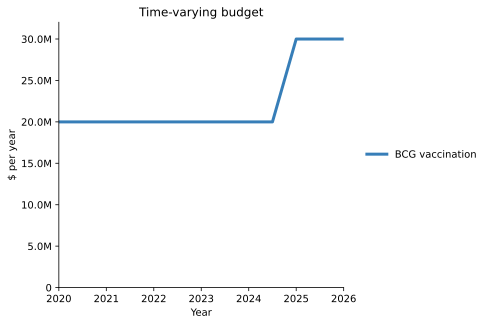

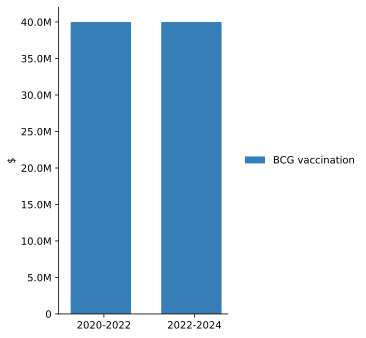

In [14]:
# SPENDING

# Raw values
d = au.PlotData.programs([result3],outputs=['BCG'],quantity='spending')
au.plot_series(d);
plt.xlim(2020,2026)

# Time aggregation over 2 years
# Spending values are summed (e.g. 22m+25m~=49m in the first 2 years)
# Notice how the axis label for the line plot is `$/year` but for the bar plot it is `$`
d = au.PlotData.programs([result3],outputs=['BCG'],quantity='spending',t_bins=np.arange(2020,2026,2))
au.plot_bars(d);

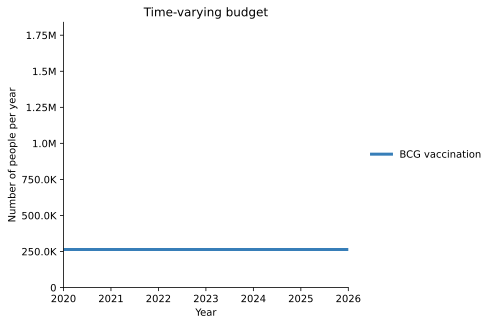

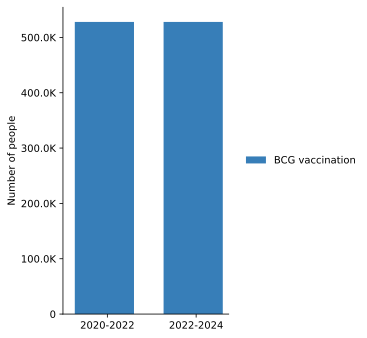

In [15]:
# Number covered

# Raw values
d = au.PlotData.programs([result3],outputs=['BCG'],quantity='coverage_number')
au.plot_series(d);
plt.xlim(2020,2026)

# Time aggregation over 2 years
# People covered per year are summed
d = au.PlotData.programs([result3],outputs=['BCG'],quantity='coverage_number',t_bins=np.arange(2020,2026,2))
au.plot_bars(d);

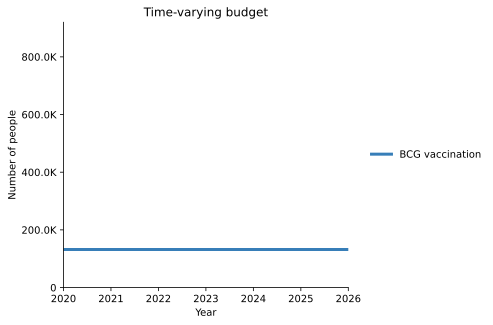

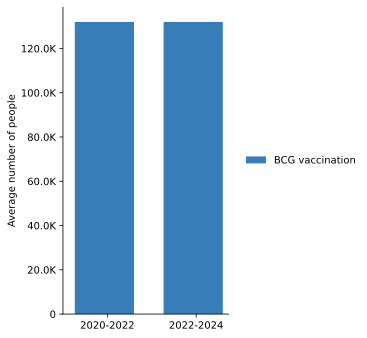

In [16]:
# Coverage eligible

# Raw values
d = au.PlotData.programs([result3],outputs=['BCG'],quantity='coverage_eligible')
au.plot_series(d);
plt.xlim(2020,2026)

# Time aggregation over 2 years
# Compartment sizes for compartments reached by a program are averaged
d = au.PlotData.programs([result3],outputs=['BCG'],quantity='coverage_eligible',t_bins=np.arange(2020,2026,2))
au.plot_bars(d);

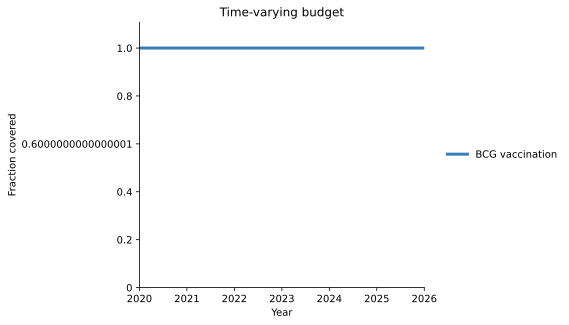

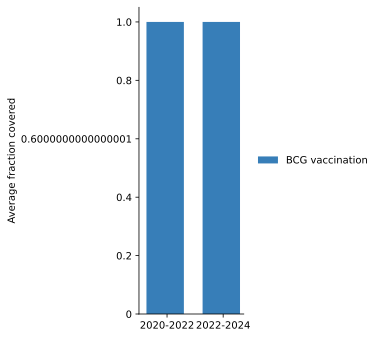

In [17]:
# Fraction covered

# Raw values
d = au.PlotData.programs([result3],outputs=['BCG'],quantity='coverage_fraction')
au.plot_series(d);
plt.xlim(2020,2026)

# Time aggregation over 2 years
# Fraction covered per year are averaged
d = au.PlotData.programs([result3],outputs=['BCG'],quantity='coverage_fraction',t_bins=np.arange(2020,2026,2))
au.plot_bars(d);

## Output aggregation

When plotting spending values, it is possible to aggregate programs in the same way that outputs can be aggregated for standard `PlotData` objects. This can only be done for programs - coverages are more complex due to modality interactions, and a system for plotting such aggregations is not yet available. 

As with aggregating outputs and pops normally, to aggregate programs, pass them in within a `dict` where the key is the name of the aggregated output, and the value is a list of the program names to include:

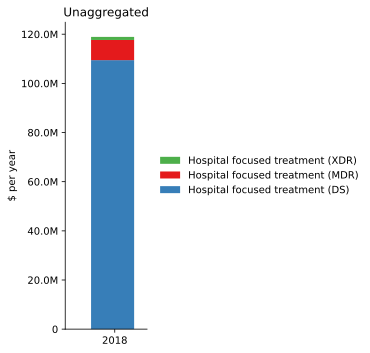

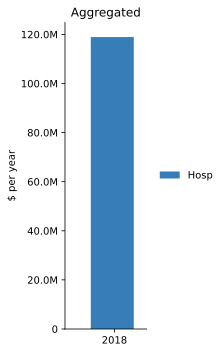

In [18]:
# Select a subset of programs
prog_list = ['HospDS','HospMDR','HospXDR']
d = au.PlotData.programs([result1],outputs=prog_list)
d.interpolate(2018)
au.plot_bars(d,stack_outputs='all')
plt.title('Unaggregated');

# Aggregate programs
outputs = {'Hosp':['HospDS','HospMDR','HospXDR']}
d = au.PlotData.programs([result1],outputs=outputs)
d.interpolate(2018)
au.plot_bars(d,stack_outputs='all')
plt.title('Aggregated');